# ETSpy Demo

This notebook demonstrates the basic use and functionality of the ETSpy package.

It covers:
* Loading simulated data
* Basic plotting of tilt series data
* Reconstruction of single slices of simulated data
* Reconstruction of the full simluated dataset
* Saving reconstructed data

## Imports
For interactive plotting, we set the Matplotlib backend to `widget`.

In addition to the `etspy` package itself we also need to import:
* PyPlot from MatplotLib
* Hyperspy

Finally, we also need to import the `datasets` module of `etspy` in order to load the simluated data we will be working with.


In [1]:
# %matplotlib inline

## Set to widget for interactive plots
%matplotlib widget

import matplotlib.pyplot as plt
import hyperspy.api as hs

import etspy.api as tomo
from etspy import datasets as ds

## Simulated Catalyst Tilt Series

### Load Data
* Read simulated catalyst tilt series as a TomoStack object
* Each image is shifted randomly to simulate specimen motion during tilt series acquisition

In [2]:
stack = ds.get_catalyst_data(misalign=True)

In [3]:
stack.metadata.Tomography

├── cropped = False
├── shifts = array([[-3.70960831,  3.44946016],
       [-4.87547689, -3.63908568],
       [ ... 87536],
       [ 0.45410401,  2.38966891],
       [-3.14193459, -3.36501969]])
├── tiltaxis = 0
├── tilts = array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
       ...  152, 154,
       156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178])
├── xshift = 0
└── yshift = 0

### Rebin the data
* To speed things up, we can rebin the dataset by a factor of 2 in the X and Y dimensions
* Uses the underlying Hyperspy rebin method which all TomoStack's inherit from their parent `Signal2D` class

In [4]:
rebin = stack.rebin(scale=[1, 2, 2])
rebin

<TomoStack, title: , dimensions: (90|300, 300)>

### Browse the Rebinned Data
* Uses Hyperspy's plotting functionality
* Plot and view the full series interactively
* Plot a max image of the dataset which emphasizes the misalignment of the stack

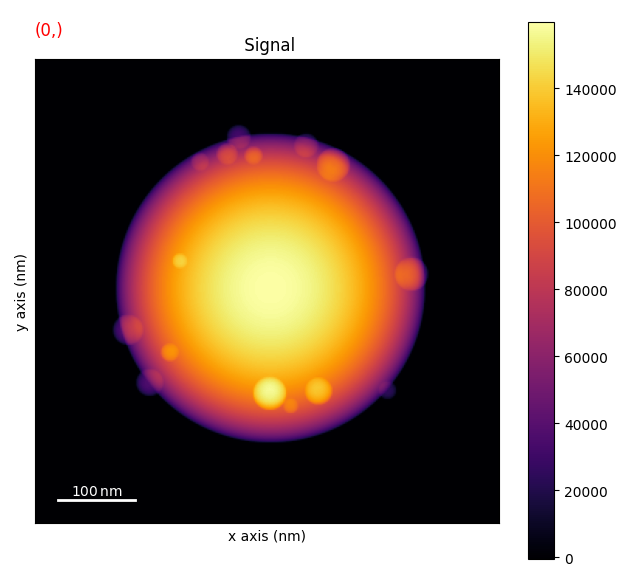

In [5]:
rebin.plot(cmap='inferno')

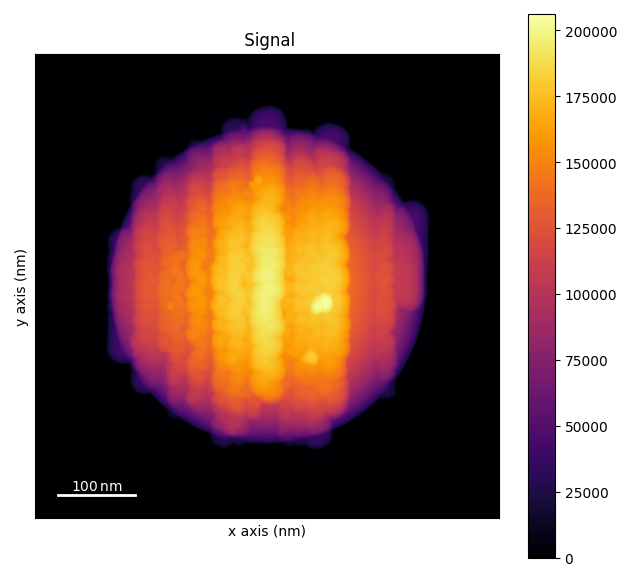

In [6]:
rebin.max().plot(cmap='inferno')

### Stack Registration
* Five methods available:
    * Phase correlation (OpenCV)
    * Enhanced correlation coefficient (OpenCV)
    * StackReg (pystackreg)
    * Center of Mass (T. Sanders et al. doi:10.13140/RG.2.2.33492.60801)
    * Combined Center of Mass and Common-Line Method (UCLA, Scott et al. doi:10.1038/nature10934)

In [7]:
reg = rebin.stack_register('StackReg')

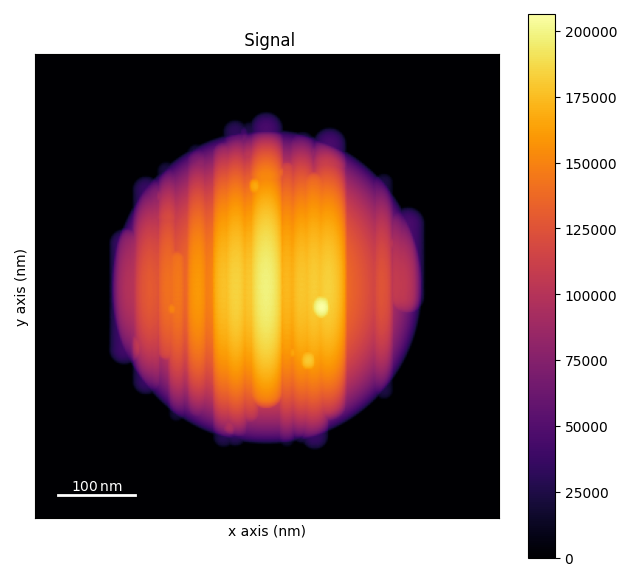

In [8]:
reg.max().plot(cmap='inferno')

### Reconstruction

#### Plot single image alongside the sinogram of the central slice

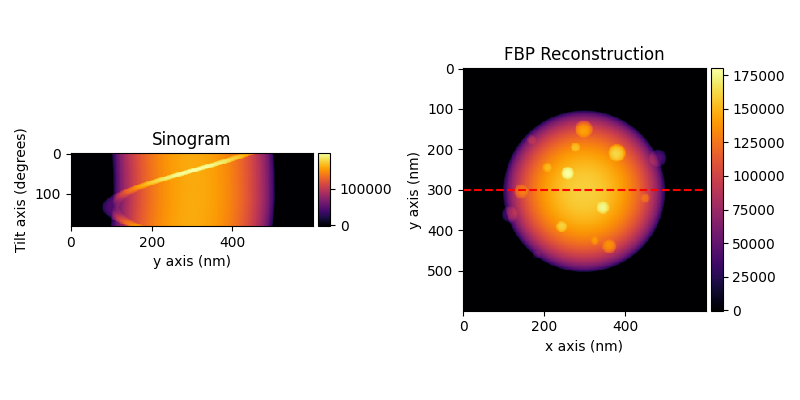

In [9]:
sino = reg.isig[150,:].as_signal2D((1,0))

ax = hs.plot.plot_images([sino, reg.inav[45]], cmap='inferno',per_row=2, label=['Sinogram','FBP Reconstruction'])
ax[1].axhline(300, linestyle='--', color='red')
plt.gcf().set_size_inches((8,4))
plt.tight_layout()

#### Filtered Backprojection of Single Slice (CPU)

In [10]:
recFBP = reg.isig[150:151, :].reconstruct('FBP', cuda=False)

[########################################] | 100% Completed | 202.84 ms


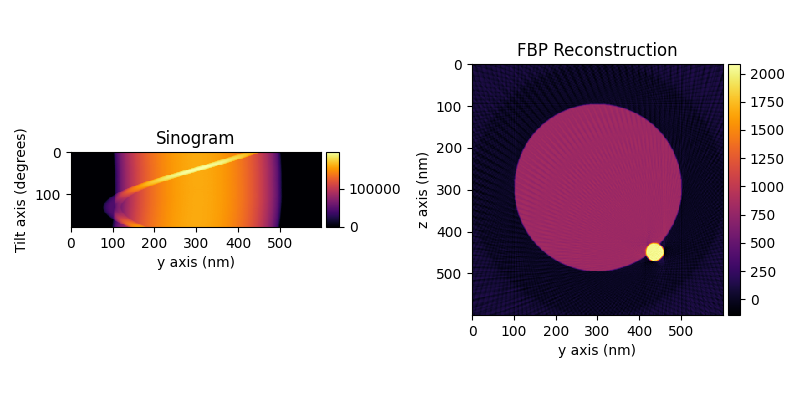

In [11]:
ax = hs.plot.plot_images([sino, recFBP], cmap='inferno',per_row=2, label=['Sinogram','FBP Reconstruction'])
plt.gcf().set_size_inches((8,4))
plt.tight_layout()

#### SIRT Error Analysis
* Perform a SIRT reconstruction and calculate the L2-norm between the forward-projection of each result and the input sinogram
* The reconstruction result is also saved at each iteration for viewing
* Note: Currently, the error output differs between CUDA- and CPU-based reconstructions.  Cause is unknown.

In [12]:
SIRTStack, SIRTerror = reg.isig[150:151, :].recon_error(iterations = 500)
SIRTStack.axes_manager[2].name = 'z'

100%|███████████████████████████████████████████████████████████████████| 500/500 [03:29<00:00,  2.39it/s]


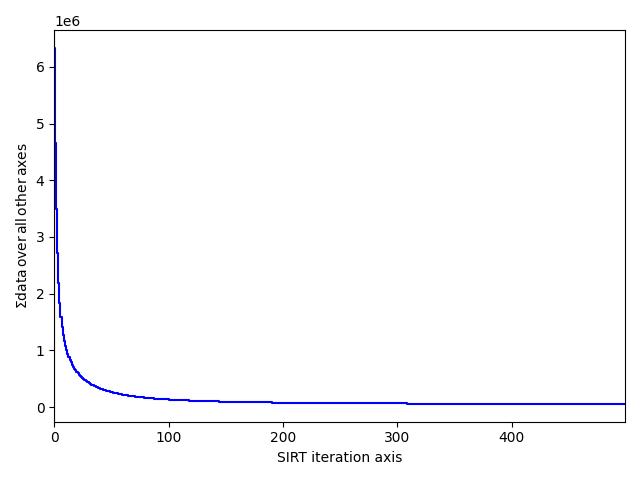

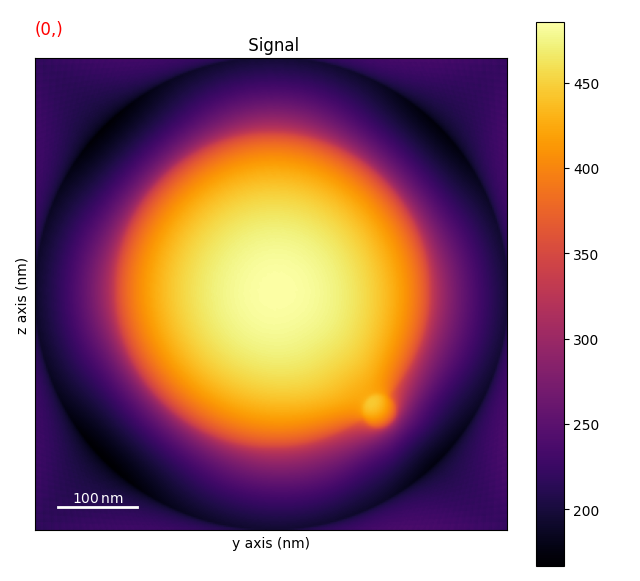

In [13]:
SIRTStack.plot(navigator=SIRTerror, cmap='inferno')

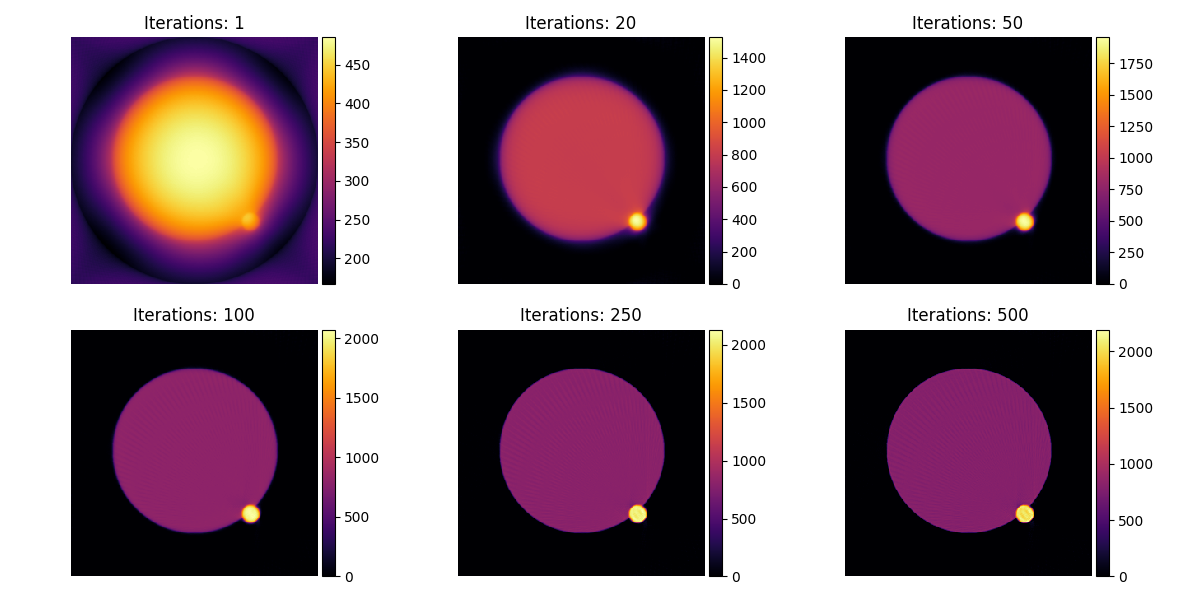

In [14]:
ax = hs.plot.plot_images([SIRTStack.inav[0],SIRTStack.inav[19],SIRTStack.inav[49],
                         SIRTStack.inav[99], SIRTStack.inav[249], SIRTStack.inav[499]], cmap='inferno',
                         axes_decor='off',
                         label=['Iterations: 1','Iterations: 20','Iterations: 50',
                                'Iterations: 100','Iterations: 250','Iterations: 500'])
plt.gcf().set_size_inches(12,6)
plt.tight_layout()

#### Reconstruct the entire binned stack
* Takes less than 10 seconds if using GPU-acceleration

In [ ]:
recFBP = reg.reconstruct('FBP', cuda=True)
recSIRT = reg.reconstruct('SIRT', iterations=100, constrain=True, cuda=True)

  0%|                                                                             | 0/300 [00:00<?, ?it/s]

In [ ]:
recFBP.plot(vmax=2000, cmap='inferno')

In [ ]:
recSIRT.plot(vmax=2000, cmap='inferno')

In [ ]:
recSIRT.swap_axes(0,2).plot(vmax=2000, cmap='inferno')

#### Save the Reconstruction Results
* Hyperspy-compatible HDF5 is the output format

In [ ]:
recFBP.save('FBP_Reconstruction.hdf5', overwrite=True, file_format='HSPY')
recSIRT.save('SIRT_Reconstruction_100.hdf5', overwrite=True, file_format='HSPY')

## Experimental Needle-shaped Sample Tilt Series
* FIB-milled specimen from NIST SRM-2135c
    * Ni/Cr mutli-layer thin film on silicon substrate

In [15]:
stack = ds.get_needle_data()

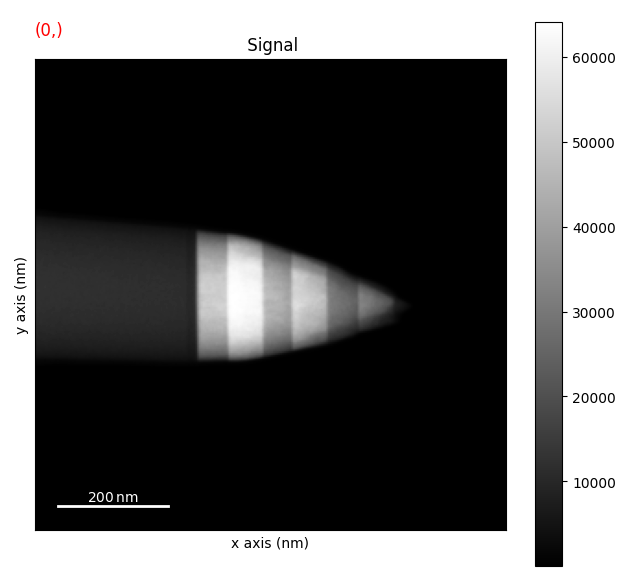

In [16]:
stack.plot(navigator='slider')

### Stack Registration
* Five methods available:
    * Phase correlation (OpenCV)
    * Enhanced correlation coefficient (OpenCV)
    * StackReg (pystackreg)
    * Center of Mass (T. Sanders et al. doi:10.13140/RG.2.2.33492.60801)
    * Combined Center of Mass and Common-Line Method (UCLA, Scott et al. doi:10.1038/nature10934)

In [17]:
reg = stack.stack_register('StackReg')

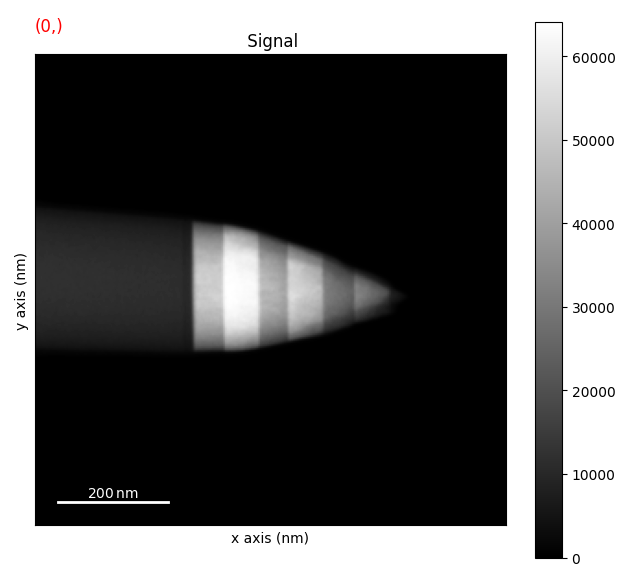

In [18]:
reg.plot(navigator='slider')

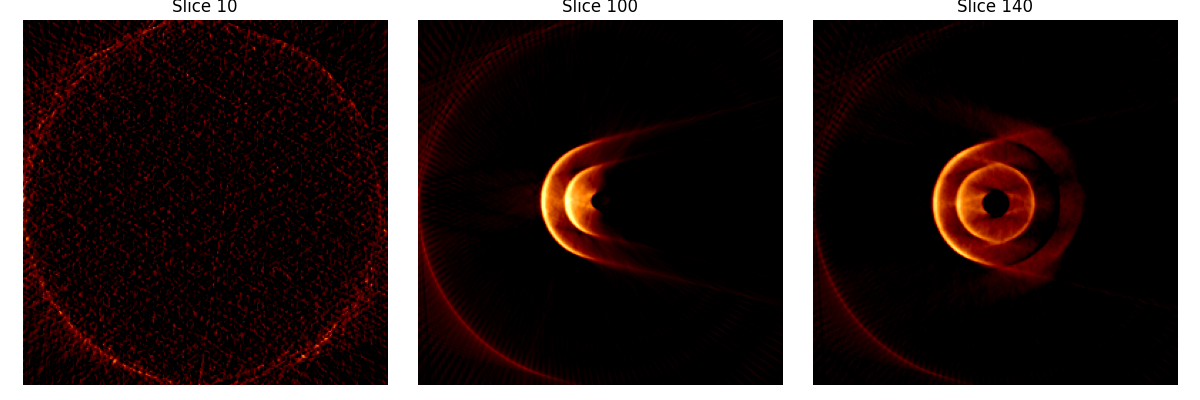

In [19]:
reg.swap_axes(1,2).test_align(slices=[10,100,140])

### Tilt Axis Alignment
* Uses the center of mass method (CoM)
* Motion of specimen is fit to that expected for an ideal cylinder
* Fit is performed for three different sinograms 
* The result is used to estimate the tilt axis shift and rotation

In [20]:
ali = reg.tilt_align('CoM')

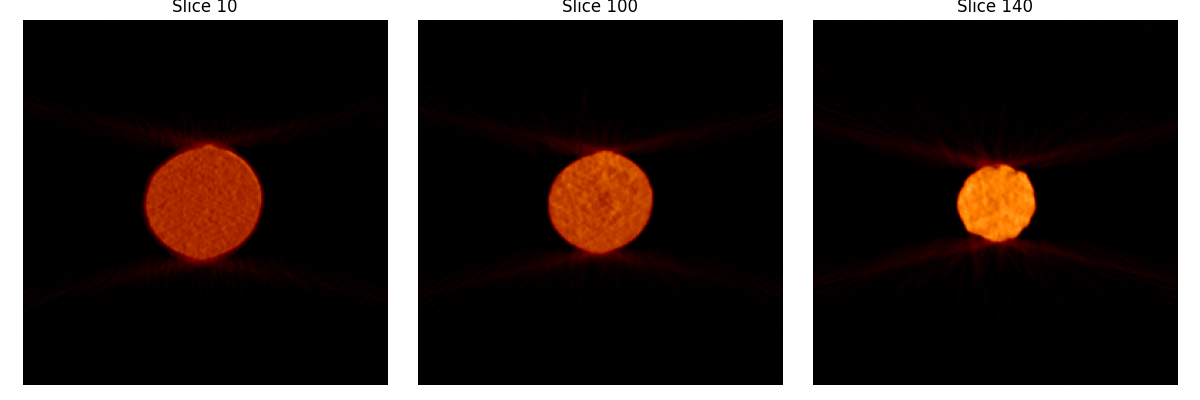

In [21]:
ali.test_align(slices=[10,100,140])

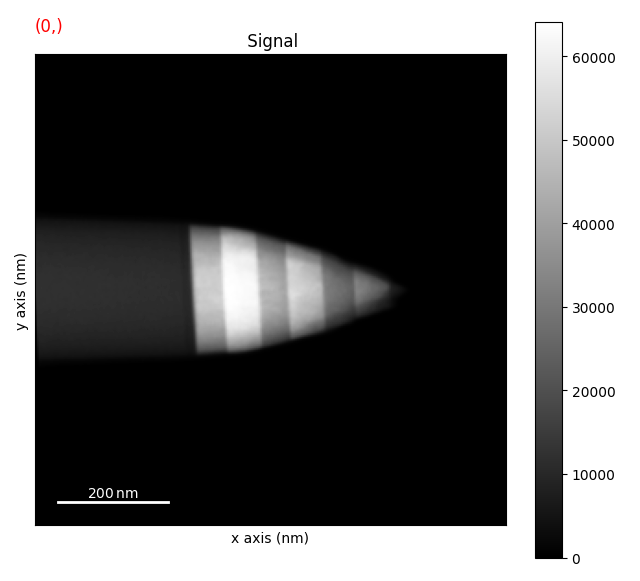

In [22]:
ali.plot()

### Reconstruction

In [23]:
rec = ali.reconstruct('SIRT', 500, constrain=True)

[                                        ] | 0% Completed | 168.84 ss


KeyboardInterrupt: 

In [ ]:
rec.inav[10:205].plot(cmap='inferno', vmin=50, vmax=1200)

In [ ]:
rec.isig[:,90:165].swap_axes(2,0).plot(cmap='inferno', vmin=50)